Education Analysis - DATA5100

In this analysis, we use the data science methodology to answer whether school performance (measured by average ACT score) can be predicted from socioeconomic factors. The notebook combines EdGap.org school-level socioeconomic variables (CT unemployment rate, percent adults with college degrees, percent of children in married-couple families, median household income, and percent free/reduced lunch) with NCES school metadata and test-score reports, then augments the analysis with EDGE program IPR (income-to-poverty-ratio) estimates to provide additional depth of understanding.

Data and preprocessing
Datasets are loaded, renamed for consistency, and merged on the NCESSCH school ID. The workflow performs data cleaning (invalid value replacement, type casting, duplicate and missing-value checks), removes non-high-school levels to focus the analysis, and uses IterativeImputer to fill remaining numeric gaps.

Exploratory analysis and visualization
Exploratory steps include pairplots, correlation heatmaps, scatter/regression plots (with IQR-based outlier removal), distribution plots for IPR, and state-level choropleths. Additional testing methodology used includes LOWESS smoothing and hexbin-like density approaches to reveal relationships while reducing noise from outliers.

Modeling intent
A set of predictor variables is defined from socioeconomic features and school metadata (state, charter). Correlation analysis guides feature selection and model-building; imputation and sampling choices are documented to support reproducibility.

Notes and limitations
The analysis highlights data limitations (reporting bias, missingness, and measurement error) and treats IPR as an additional socioeconomic indicator in later merges. The final cleaned dataframe is prepared for predictive modeling to quantify how well socioeconomic factors explain variability in average ACT scores and to assess remaining confounders and uncertainty.

Load and interpret data set

Import code libraries

In [ ]:
# Import standard data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Seaborn is a data visualization library built on matplotlib
import seaborn as sns

#Set the plotting style
sns.set_style("whitegrid")

Load the data

Read EdGap excel file

Read NCES ACT score csv file

In [6]:
#Read Excel and CSV data
edgap = pd.read_excel('..\data\EdGap_data.xlsx')
scores = pd.read_csv('..\data\ccd_sch_029_1617_w_1a_11212017.csv', encoding="unicode_escape", low_memory=False)

c:\Users\hrvel\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Explore general content of the data set for EdGap using info()

In [7]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   int64  
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB


The EdGap data contains just under 8 thousand entries for schools across the US that chose to share the requested economic data. The primary key for this data set is the NCESSCH ID.

Explore general content and format of ACT scoring data using info()

In [8]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

The ACT and SAT scores have been reported by every school in the US which gives us over 100 thousand entries in this CSV. This data set also uses NCESSCH ID as a primary key, and can be used to join the two.

Plot pairplot for all columns, excluding the school ID for clarity, to visualize relationships between variables for both datasets

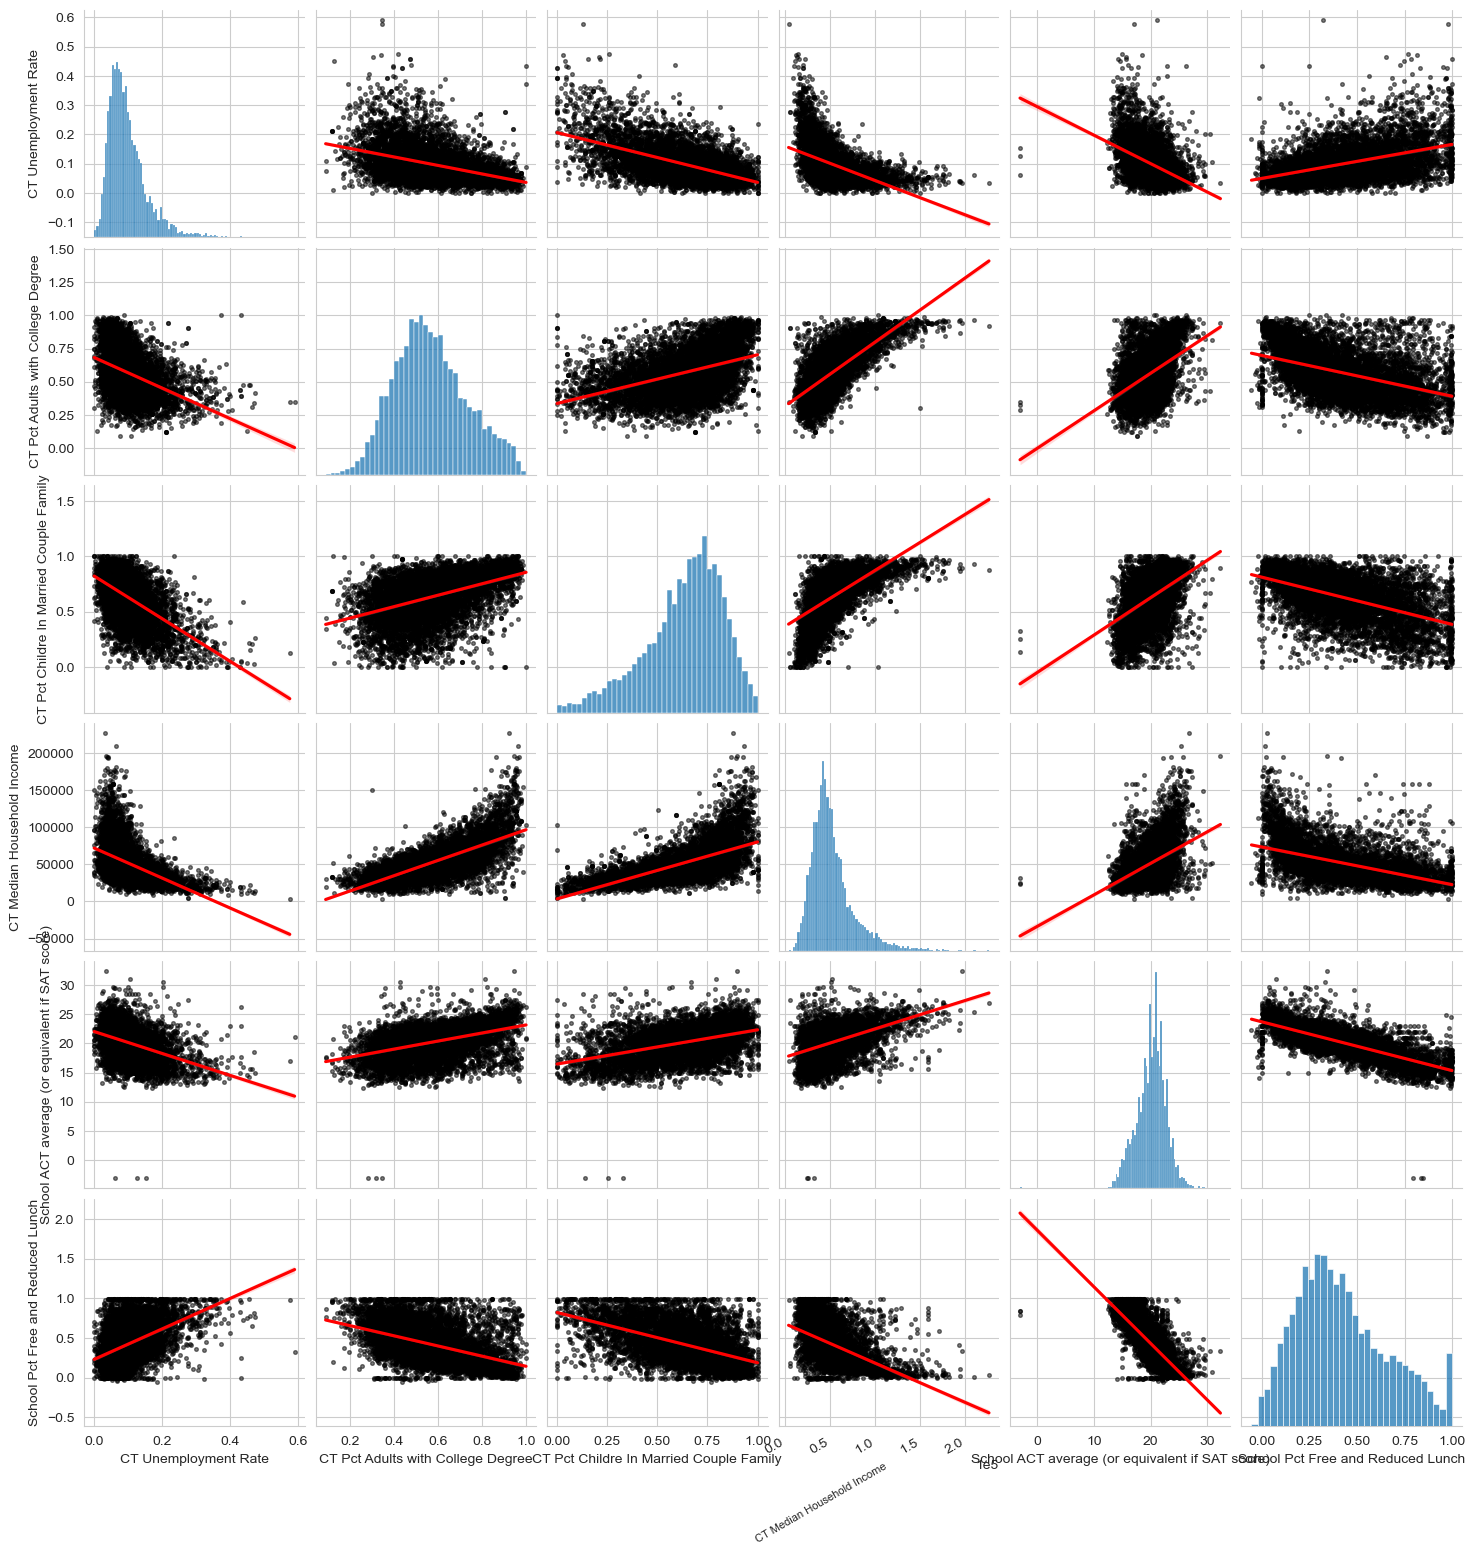

In [ ]:
# Pairplot with regression lines for EdGap data
fig = sns.pairplot(
    edgap.drop(columns="NCESSCH School ID"),
    kind="reg",
    plot_kws={
            "line_kws":{"color":"red"},
            "scatter_kws":{"alpha":0.5, "color": "k", "s":7},
    },
)
# Customize axes for better readability
for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #Apply scientific notation
        ax.set_xlabel(ax.get_xlabel(), fontsize = 8, rotation=30, ha='right') #X-axis label and size rotation
        ax.set_ylabel(ax.get_ylabel(), fontsize = 8) #Y-axis label size

        plt.setp(ax.get_xticklabels(), rotation = 30, ha='right') #Rotate X-axis tick labels
plt.show()

This pairplot provides a general overview of the two dataframes and how they correlate with each other. At a glance, there are several significant outliers that need to be addressed, but we're able to see the positive and negative correlations for each demographic datapoint.

Scatter plot with regression line to visualize the relationship between median household income and average ACT score more closely without outliers

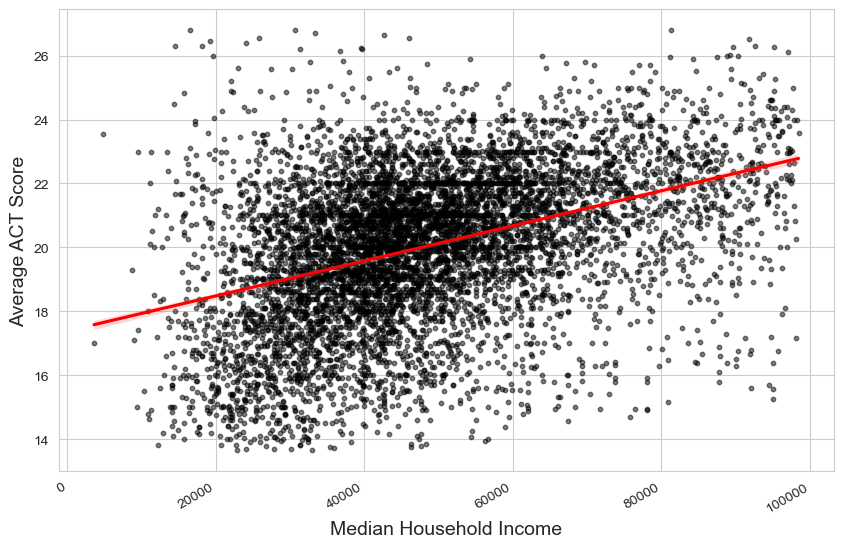

In [ ]:
# Remove outliers using IQR for both columns
income_q1 = edgap['CT Median Household Income'].quantile(0.25)
income_q3 = edgap['CT Median Household Income'].quantile(0.75)
income_iqr = income_q3 - income_q1

act_q1 = edgap['School ACT average (or equivalent if SAT score)'].quantile(0.25)
act_q3 = edgap['School ACT average (or equivalent if SAT score)'].quantile(0.75)
act_iqr = act_q3 - act_q1

# Filtered EdGap DataFrame without outliers
filtered_edgap = edgap[
    (edgap['CT Median Household Income'] >= income_q1 - 1.5 * income_iqr) &
    (edgap['CT Median Household Income'] <= income_q3 + 1.5 * income_iqr) &
    (edgap['School ACT average (or equivalent if SAT score)'] >= act_q1 - 1.5 * act_iqr) &
    (edgap['School ACT average (or equivalent if SAT score)'] <= act_q3 + 1.5 * act_iqr)
]

# Scatter plot with regression line after removing outliers
plt.figure(figsize=(10, 6))
sns.regplot(
    data=filtered_edgap,
    x='CT Median Household Income',
    y='School ACT average (or equivalent if SAT score)',
    scatter_kws={'alpha':0.5, 'color':'k', 's':10},
    line_kws={'color':'red'}
)
plt.xlabel('Median Household Income', fontsize=14)
plt.ylabel('Average ACT Score', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.show()

This simple regression plot does show a positive correlation between ACT scores and median household income, but the data processing shows that the degree of correlation is lower than the other variables being measured against ACT scoring.

Extract relevant school information from the scores dataframe

In [ ]:
school_information = scores[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
    ]
school_information.head()

,SCHOOL_YEAR,NCESSCH,LSTATE,LZIP,SCH_TYPE_TEXT,LEVEL,CHARTER_TEXT
0,2016-2017,1.000020e+10,AL,35220,Alternative School,High,No
1,2016-2017,1.000020e+10,AL,36067,Alternative School,High,No
2,2016-2017,1.000020e+10,AL,36784,Alternative School,High,No
3,2016-2017,1.000020e+10,AL,36057,Alternative School,High,No
4,2016-2017,1.000020e+10,AL,35206,Alternative School,High,No


Rename columns in EdGap dataframe for clarity and consistency

In [ ]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID":"id"
        , "CT Pct Adults with College Degree":"percent_college"
        , "CT Unemployment Rate":"rate_unemployment"
        , "CT Pct Childre In Married Couple Family":"percent_married"
        , "CT Median Household Income":"median_income"
        , "School ACT average (or equivalent if SAT score)":"average_act"
        , "School Pct Free and Reduced Lunch":"percent_lunch"
    }
)

Verify new column names

In [ ]:
edgap.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


Rename columns in school information dataframe for clarity and consistency

In [ ]:
school_information = school_information.rename(
    columns={
        "SCHOOL_YEAR":"year"
        , "NCESSCH":"id"
        , "LSTATE":"state"
        , "LZIP":"zip_code"
        , "SCH_TYPE_TEXT":"school_type"
        , "LEVEL":"school_level"
        , "CHARTER_TEXT":"charter"
    }
)

Cast school ID to object type for to enable merging with EdGap dataframe

In [ ]:
school_information['id'] = school_information['id'].astype('object')

Verify new column names and ID type

In [ ]:
school_information.head()

,year,id,state,zip_code,school_type,school_level,charter
0,2016-2017,10000200277.0,AL,35220,Alternative School,High,No
1,2016-2017,10000201667.0,AL,36067,Alternative School,High,No
2,2016-2017,10000201670.0,AL,36784,Alternative School,High,No
3,2016-2017,10000201705.0,AL,36057,Alternative School,High,No
4,2016-2017,10000201706.0,AL,35206,Alternative School,High,No


Merge EdGap dataframe with school information dataframe on school ID

In [ ]:
df = edgap.merge(
    school_information,
    how='left',
    on='id'
)

Verify merged dataframe structure

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   object 
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
 7   year               7898 non-null   object 
 8   state              7898 non-null   object 
 9   zip_code           7898 non-null   object 
 10  school_type        7898 non-null   object 
 11  school_level       7898 non-null   object 
 12  charter            7898 non-null   object 
dtypes: float64(6), object(7)
memory usage: 811.2+ KB


In addition to the school-level data files, the NCES provides a set of files that contain estimates of the economic characteristics of the families of public school students. These files are part of the NCES Education Demographic and Geographic Estimates (EDGE) program. The EDGE program uses data from the American Community Survey (ACS) to produce estimates of the economic characteristics of families with children enrolled in public schools. The EDGE program produces estimates for all public schools in the 50 states and Washington DC. 
The estimates reflect the income-to poverty ratio (IPR), which is the percentage of family income that is above or below the federal poverty threshold set for the family’s size and structure. The IPR indicator ranges from 0 to 999. Lower IPR values indicate a greater degree of poverty. Each file includes IPR estimates and standard errors for approximately 100,000 public school locations in the 50 states and Washington DC. 

Import poverty level csv file

In [ ]:
ipr_level = pd.read_csv('..\data\EDGE_poverty_estimates.csv', encoding="unicode_escape")

Rename NCESSCH to id for consistency and to enable merging

In [ ]:
ipr_level = ipr_level.rename(columns={'NCESSCH':'id'})

Verify column names and data structure

In [ ]:
ipr_level.head()

,id,NAME,IPR_EST,IPR_SE
0,10000200277,Sequoyah Sch - Chalkville Campus,252,112
1,10000201667,Camps,217,71
2,10000201670,Det Ctr,290,77
3,10000201705,Wallace Sch - Mt Meigs Campus,267,78
4,10000201706,McNeel Sch - Vacca Campus,172,56


Merge the combined EdGap and school information dataframe with the poverty level data on school ID

In [ ]:
df_ipr = df.merge(
    ipr_level,
    how='left',
    on='id'
)

Verify final merged dataframe structure and data types

In [ ]:
df_ipr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   object 
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
 7   year               7898 non-null   object 
 8   state              7898 non-null   object 
 9   zip_code           7898 non-null   object 
 10  school_type        7898 non-null   object 
 11  school_level       7898 non-null   object 
 12  charter            7898 non-null   object 
 13  NAME               7898 non-null   object 
 14  IPR_EST            7898 non-null   float64
 15  IPR_SE             7898 non-null   float64
dtypes: float64(8), object(8)

Visualize missing values in the final dataframe

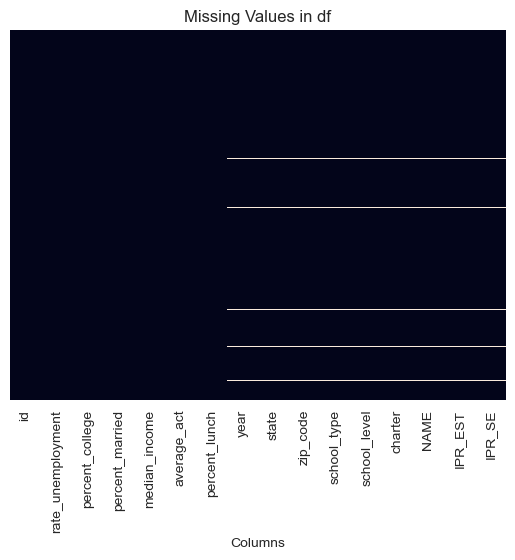

In [ ]:
sns.heatmap(df_ipr.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in df")
plt.xlabel("Columns")
plt.show()

Plot IPR estimates with standard error bars for the top 20 schools by IPR estimate to help understand the distribution of standard error for high income school zones

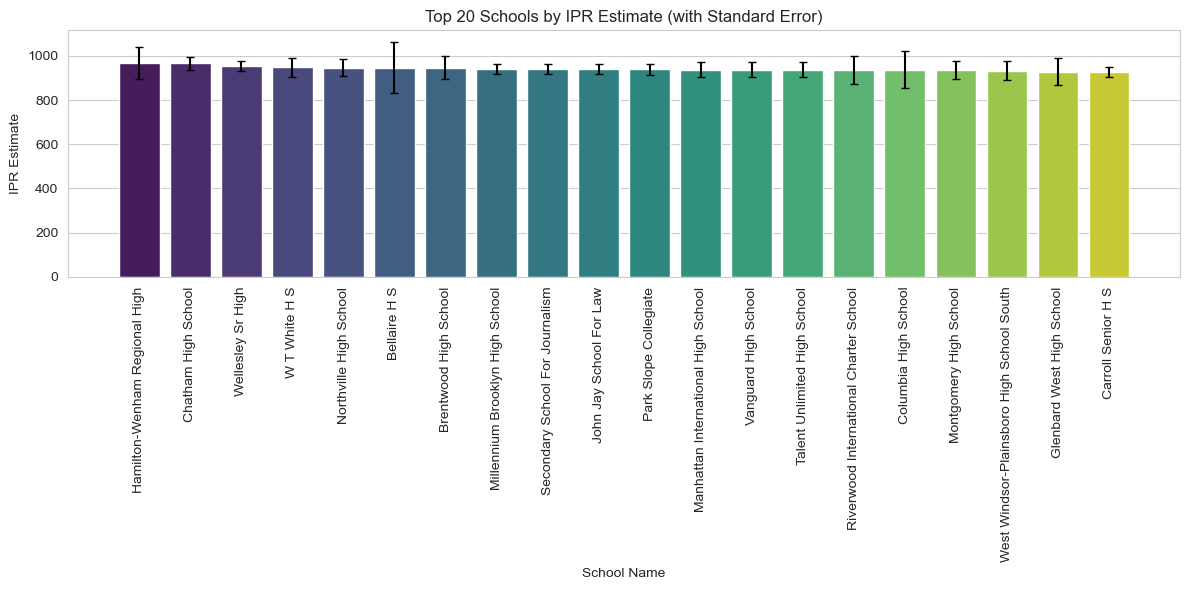

In [ ]:
# Calculate IPR Standard Error (SE) by school ID and plot IPR estimates with school names
df_ipr_sorted = df_ipr.sort_values('IPR_EST', ascending=False).head(20)  # Top 20 schools by IPR estimate
df_ipr_sorted['IPR_EST'] = pd.to_numeric(df_ipr_sorted['IPR_EST'], errors='coerce') # Convert to numeric, coercing errors to NaN
df_ipr_sorted['IPR_SE'] = pd.to_numeric(df_ipr_sorted['IPR_SE'], errors='coerce') # Convert to numeric, coercing errors to NaN
df_ipr_sorted['NAME'] = df_ipr_sorted['NAME'].str.title() # Title case for school names

# Plot bar chart with error bars
plt.figure(figsize=(12,6))
sns.barplot(x='NAME', y='IPR_EST', data=df_ipr_sorted, palette='viridis', hue='NAME')
plt.errorbar(x=range(len(df_ipr_sorted)), y=df_ipr_sorted['IPR_EST'], yerr=df_ipr_sorted['IPR_SE'], fmt='none', ecolor='black', capsize=3)
plt.xticks(ticks=range(len(df_ipr_sorted)), labels=df_ipr_sorted['NAME'], rotation=90)
plt.xlabel('School Name')
plt.ylabel('IPR Estimate')
plt.title('Top 20 Schools by IPR Estimate (with Standard Error)')
plt.tight_layout()
plt.show()

In this plot, we see that the degree of error among the 20 top schools by IPR is pretty minimal. In order to evaluate the inverse of this inquiry, we will also produce a graph for the bottom 20 schools by IPR.

Plot IPR estimates with standard error bars for the bottom 20 schools by IPR estimate to visualize the distribution of standard error for low income school zones

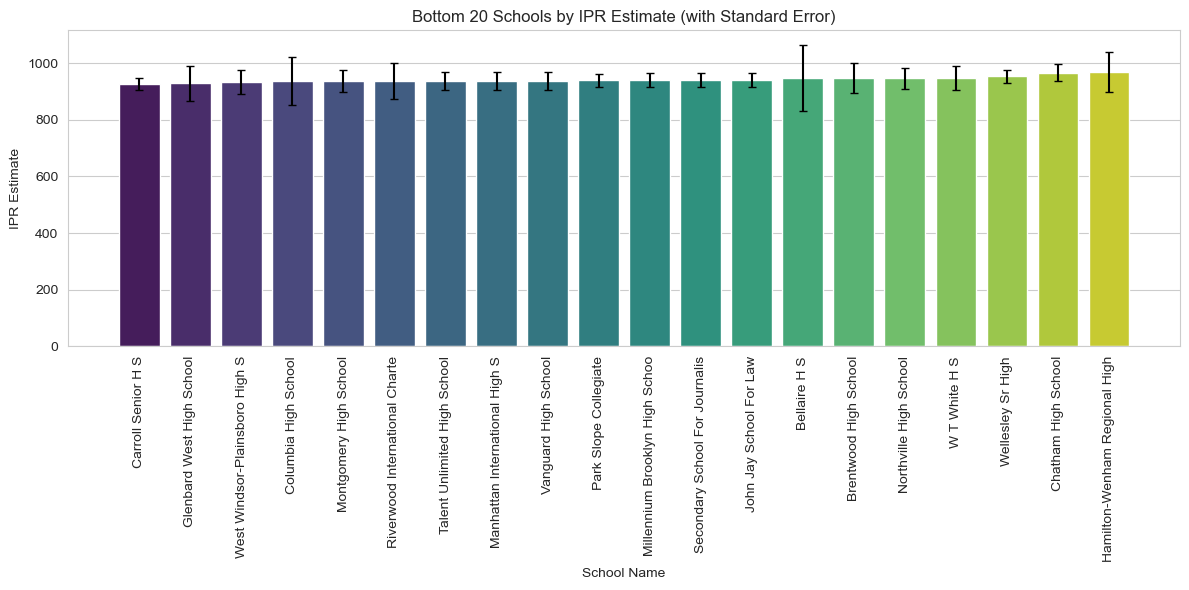

In [ ]:
# Plot the bottom 20 schools by IPR estimate (excluding NULLs), with standard error whiskers and truncated names
df_ipr_sorted['IPR_EST'] = pd.to_numeric(df_ipr_sorted['IPR_EST'], errors='coerce') # Convert to numeric, coercing errors to NaN
df_ipr_sorted['IPR_SE'] = pd.to_numeric(df_ipr_sorted['IPR_SE'], errors='coerce') # Convert to numeric, coercing errors to NaN
df_ipr_sorted['NAME'] = df_ipr_sorted['NAME'].str.title().str.slice(0, 30)  # Title case and truncate school names to 30 characters
df_ipr_sorted = df_ipr_sorted[df_ipr_sorted['IPR_EST'].notnull()] # Exclude rows with NULL IPR estimates
df_ipr_bottom20 = df_ipr_sorted.nsmallest(20, 'IPR_EST') # Bottom 20 schools by IPR estimate

# Plot bar chart with error bars
plt.figure(figsize=(12,6))
sns.barplot(x='NAME', y='IPR_EST', data=df_ipr_bottom20, palette='viridis', hue='NAME')
plt.errorbar(x=range(len(df_ipr_bottom20)), y=df_ipr_bottom20['IPR_EST'], yerr=df_ipr_bottom20['IPR_SE'], fmt='none', ecolor='black', capsize=3)
plt.xticks(ticks=range(len(df_ipr_bottom20)), labels=df_ipr_bottom20['NAME'], rotation=90)
plt.xlabel('School Name')
plt.ylabel('IPR Estimate')
plt.title('Bottom 20 Schools by IPR Estimate (with Standard Error)')
plt.tight_layout()
plt.show()

The standard error among the bottom 20 schools is much larger. I believe this indicates how often we can expect to see errors across the various levels of poverty across schools in America. Now I'd like to know what is the spread of IPR scores across schools, which we can plot using a bar chart.

Create a visual overview for the distribution of IPR estimates across all schools

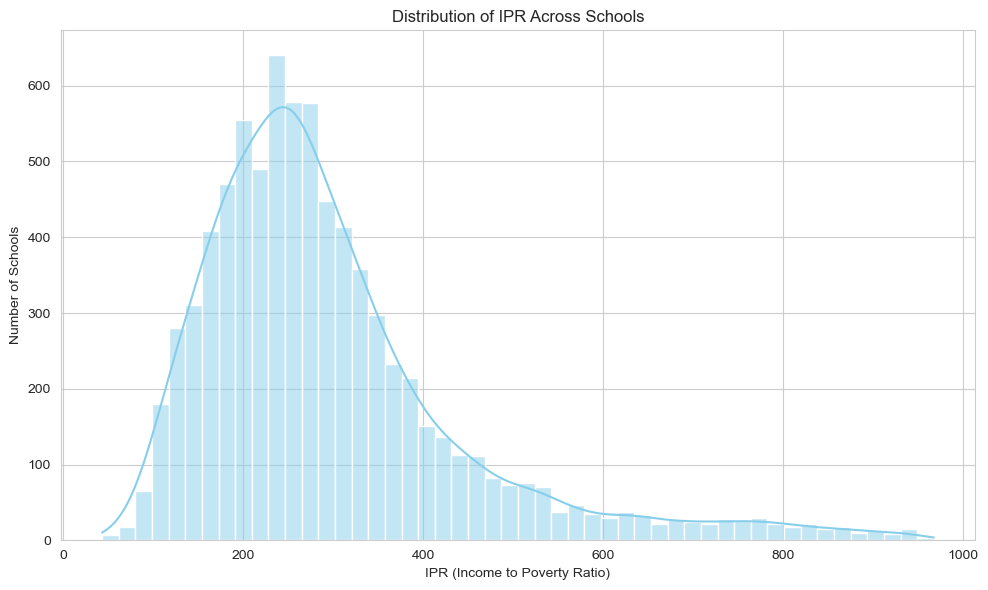

In [ ]:
# Plot histogram of IPR estimates
plt.figure(figsize=(10,6))
sns.histplot(df_ipr['IPR_EST'], bins=50, kde=True, color='skyblue')
plt.xlabel('IPR (Income to Poverty Ratio)')
plt.ylabel('Number of Schools')
plt.title('Distribution of IPR Across Schools')
plt.tight_layout()
plt.show()

Most of the schools report an IPR under 400, where 500 would be what you'd start to consider an area to be high income. I want to create a visual to plot a random sample of IPR scores and their standard error, which would best be represented using a box and whisker plot. 

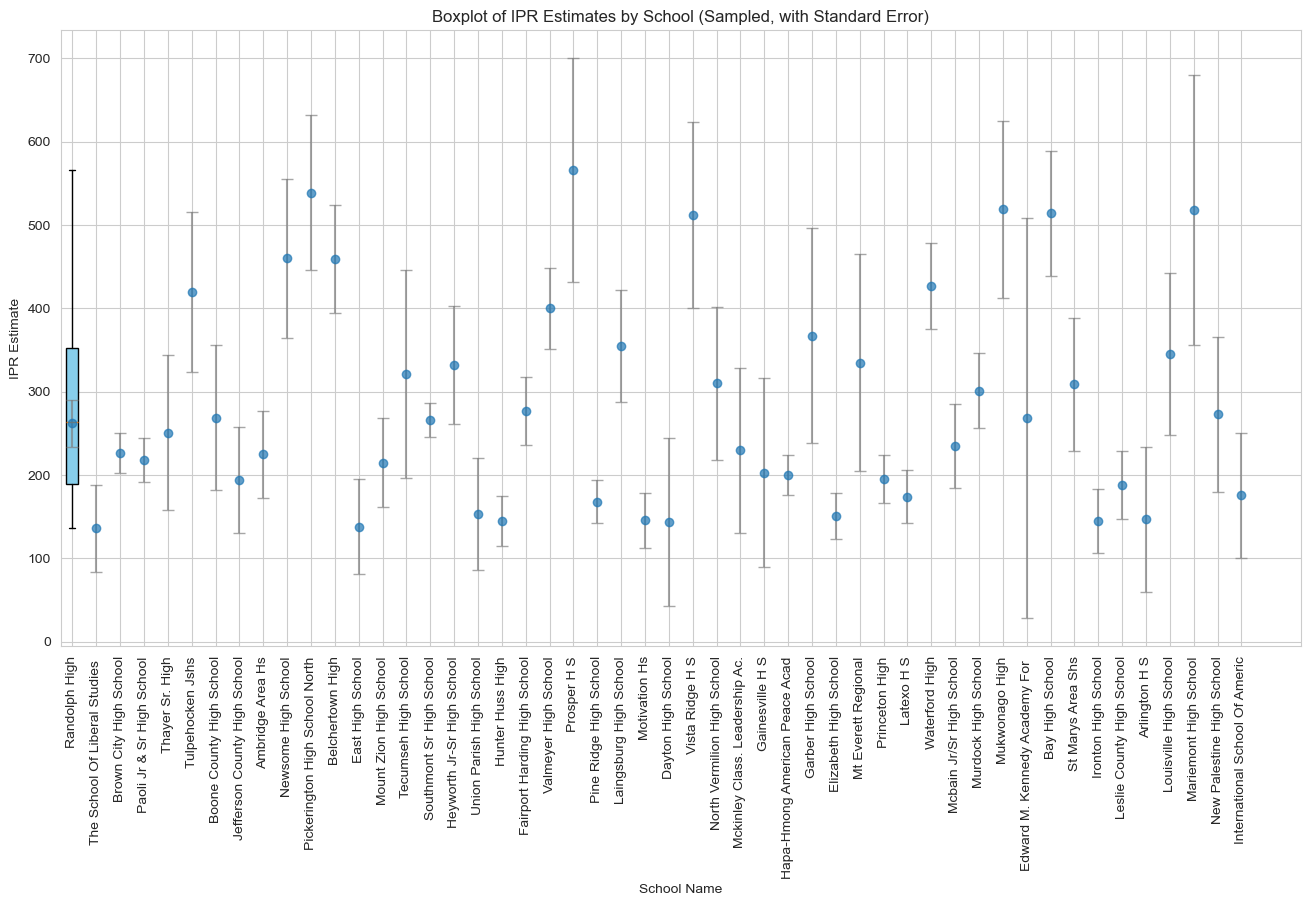

In [56]:
# Boxplot of IPR estimates by school (sampled for clarity, excluding NULLs), with standard error as whiskers
boxplot_sample = df_ipr.copy()
boxplot_sample['IPR_EST'] = pd.to_numeric(boxplot_sample['IPR_EST'], errors='coerce') # Convert to numeric, coercing errors to NaN
boxplot_sample['IPR_SE'] = pd.to_numeric(boxplot_sample['IPR_SE'], errors='coerce') # Convert to numeric, coercing errors to NaN
boxplot_sample['NAME'] = boxplot_sample['NAME'].str.title().str.slice(0, 30) # Title case and truncate school names to 50 characters
boxplot_sample = boxplot_sample[boxplot_sample['IPR_EST'].notnull()] # Exclude rows with NULL IPR estimates
boxplot_sample = boxplot_sample.sample(n=50, random_state=42) # Random sample of 50 schools for clarity

# Plot boxplot with error bars
plt.figure(figsize=(16,8))
positions = range(len(boxplot_sample))
plt.boxplot(boxplot_sample['IPR_EST'], positions=[0], widths=0.5, vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.errorbar(x=positions, y=boxplot_sample['IPR_EST'], yerr=boxplot_sample['IPR_SE'], fmt='o', ecolor='gray', capsize=4, markersize=6, alpha=0.7, label='IPR Estimate ± SE')
plt.xticks(positions, boxplot_sample['NAME'], rotation=90)
plt.xlabel('School Name')
plt.ylabel('IPR Estimate')
plt.title('Boxplot of IPR Estimates by School (Sampled, with Standard Error)')
plt.show()

Upon reviewing random samples of school IPR scores, there is certainly a large degree of error when schools are reporting their own data. What would be the best way to minimize the errors we see in human reported values? Using an AI assistant, I requested an example plot with suggestions for removing noise and improving accuracy in the 3 data sets.

Remove IQR outliers for average_act and IPR_EST, then plot (hexbin + binned median) to reduce noise

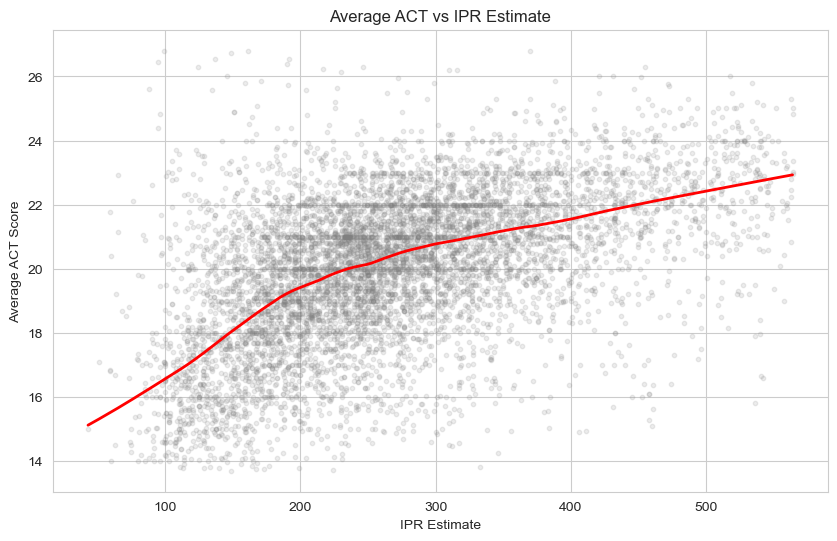

In [57]:
import scipy.stats as stats
# Prepare data and coerce to numeric
plot_df = df_ipr[["average_act", "IPR_EST", "IPR_SE"]].copy()
plot_df['average_act'] = pd.to_numeric(plot_df['average_act'], errors='coerce')
plot_df['IPR_EST'] = pd.to_numeric(plot_df['IPR_EST'], errors='coerce')
plot_df['IPR_SE'] = pd.to_numeric(plot_df['IPR_SE'], errors='coerce')
plot_df = plot_df.dropna(subset=['average_act', 'IPR_EST'])

# Compute IQR bounds for both variables
a_q1, a_q3 = plot_df['average_act'].quantile([0.25, 0.75])
a_iqr = a_q3 - a_q1
a_low, a_high = a_q1 - 1.5 * a_iqr, a_q3 + 1.5 * a_iqr
ipr_q1, ipr_q3 = plot_df['IPR_EST'].quantile([0.25, 0.75])
ipr_iqr = ipr_q3 - ipr_q1
ipr_low, ipr_high = ipr_q1 - 1.5 * ipr_iqr, ipr_q3 + 1.5 * ipr_iqr

# Filter to non-outlier range on both axes
filtered = plot_df[plot_df['average_act'].between(a_low, a_high) & plot_df['IPR_EST'].between(ipr_low, ipr_high)].copy()
removed = len(plot_df) - len(filtered)

# Scatter plot (alpha) to show point density without heatmap/binning
plt.figure(figsize=(10,6))
plt.scatter(filtered['IPR_EST'], filtered['average_act'], s=10, color='gray', alpha=0.15, label='Reporting Schools', rasterized=False)
plt.xlabel('IPR Estimate')
plt.ylabel('Average ACT Score')
plt.title('Average ACT vs IPR Estimate')
# Overlay a smoothed trend line using LOWESS (fall back to interpolated smoothing if statsmodels not available)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_smoothed = lowess(filtered['average_act'], filtered['IPR_EST'], frac=0.2)
    plt.plot(lowess_smoothed[:,0], lowess_smoothed[:,1], color='red', linewidth=2)
except Exception:
    # Fallback: sort points, interpolate onto a regular grid and smooth (no binning)
    x = filtered['IPR_EST'].values
    y = filtered['average_act'].values
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    if len(x_sorted) >= 3:
        x_grid = np.linspace(x_sorted.min(), x_sorted.max(), 200)
        y_interp = np.interp(x_grid, x_sorted, y_sorted)
        from scipy.ndimage import gaussian_filter1d
        y_smooth = gaussian_filter1d(y_interp, sigma=2)
        plt.plot(x_grid, y_smooth, color='red', linewidth=2)
plt.show()

Final data cleaning: Replace invalid values with NaN for percent_lunch and average_act columns

In [ ]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

View counts of different school types

In [ ]:
df['school_type'].value_counts()

school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

View counts of different school levels

In [ ]:
df['school_level'].value_counts()  

school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

View counts of charter vs non-charter schools

In [ ]:
df['charter'].value_counts()

charter
No                7329
Yes                352
Not applicable     217
Name: count, dtype: int64

Limit the dataframe to only look at reporting high schools

In [ ]:
df = df.loc[df['school_level'] == 'High']

Check for duplicate rows in the dataframe

In [ ]:
df.duplicated().sum()

np.int64(0)

View total missing values by column

In [ ]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,12
percent_college,11
percent_married,20
median_income,16
average_act,3
percent_lunch,20
year,0
state,0
zip_code,0


View counts of different states in the dataframe

In [ ]:
df['state'].value_counts()  

state
TX    913
OH    654
IL    564
PA    543
MI    498
NC    407
FL    404
GA    367
WI    351
NJ    341
MO    337
IN    321
NY    295
TN    265
WA    263
MA    253
KY    198
LA    194
WY     38
DE     24
Name: count, dtype: int64

Import Plotly for interactive visualizations

In [ ]:
import plotly.offline as po
import plotly.graph_objs as pg

Create a heatmap of school counts by state

In [ ]:
layout = dict(
    geo ={"scope":"usa"}, coloraxis_colorbar=dict(title="Number of Schools")
)
data = dict(
    type = "choropleth",
    locations = df['state'].value_counts().index,
    locationmode = 'USA-states',
    z=df['state'].value_counts().values,
    coloraxis="coloraxis",
)
x = pg.Figure(data=[data], layout=layout)
po.iplot(x)

Remove rows with missing average ACT scores for analysis

In [ ]:
df = df.dropna(subset='average_act')

View total missing values by column, verify all missing values for average_act have been assigned as NaN (Not a Number)

In [ ]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,12
percent_college,11
percent_married,20
median_income,16
average_act,0
percent_lunch,20
year,0
state,0
zip_code,0


Create a list of predictor variables for modeling

In [ ]:
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter'
]

Import IterativeImputer for imputation (insertion) of missing values

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()

Identify numerical predictor variables for imputation

In [ ]:
numerical_predictors = df[predictor_variables].select_dtypes(include=['number']).columns.to_list()
print(numerical_predictors)

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch']


Fit the imputer on the numerical predictor variables and transform the data to fill in missing values

In [ ]:
imputer.fit(df[numerical_predictors])
df[numerical_predictors] = imputer.transform(df[numerical_predictors])

Verify final dataframe contains no missing values

In [ ]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,0
percent_lunch,0
year,0
state,0
zip_code,0


Export cleaned dataframe to CSV for modeling

In [ ]:
df.to_csv('../data/cleaned_education_data.csv', encoding='utf-8-sig', index=False)

Reimport cleaned dataframe when needed

In [48]:
df = pd.read_csv('../data/cleaned_education_data.csv', encoding='utf-8-sig')

Compute correlation matrix and plot heatmap with proper color scaling

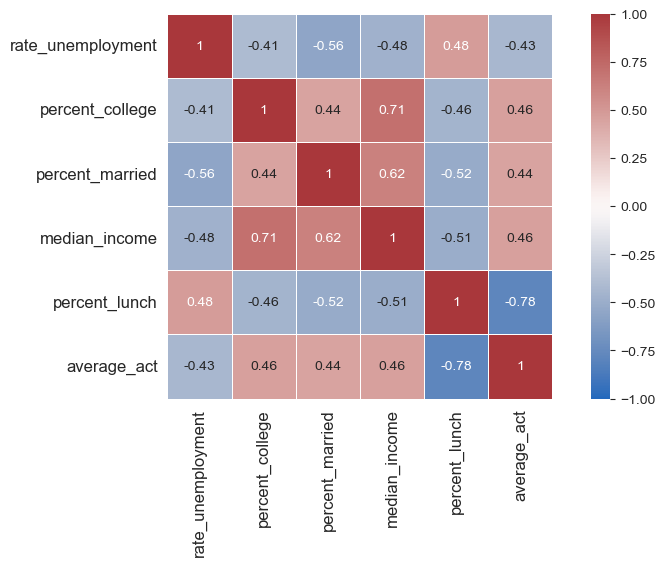

In [ ]:
corr_matrix = df[numerical_predictors + ["average_act"]].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    vmin=-1, vmax=1,
    center=0,
    cmap="vlag",
    square=True,
    linewidths=0.5,
)
plt.tick_params(labelsize=12)
plt.show()

Create new pairplot of cleaned dataframe with separate regression lines by school Charter type to produce more accurate visuals between variables

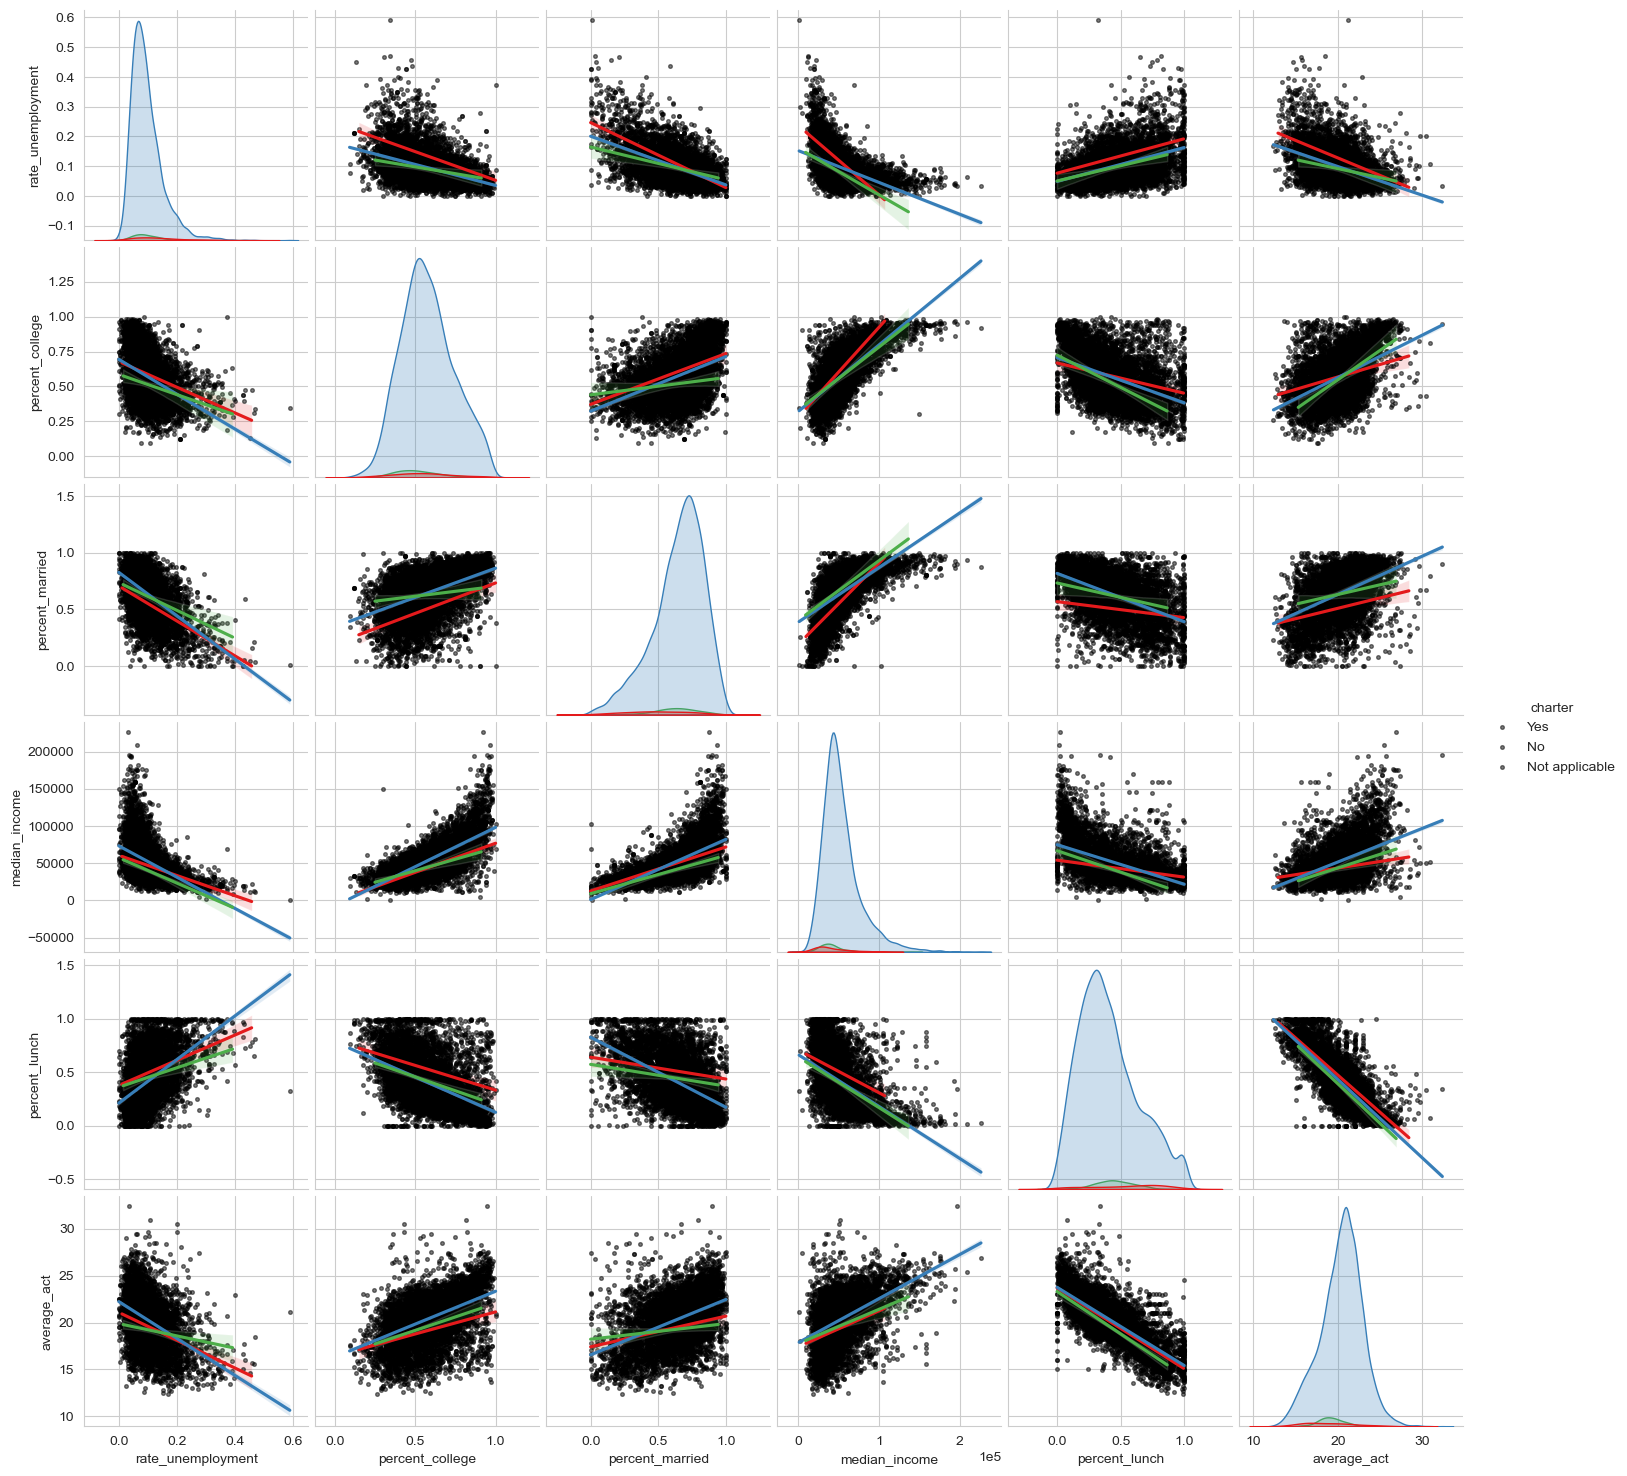

In [ ]:
# New pairplot of cleaned dataframe with separate regression lines by school Charter type
fig = sns.pairplot(
    data= df,
    vars=numerical_predictors + ["average_act"],
    hue='charter',
    kind='reg',
    #plot_kws={"scatter_kws":{"alpha":0.5, "color": "k", "s":7},
    palette='Set1',
    plot_kws={"line_kws": {}, "scatter_kws": {"alpha": 0.5, "s": 7, "color": "k"}},
    
)
# Customize axes for better readability
for ax in fig.axes.flat:
    if ax.get_xlabel() == 'median_income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #Apply scientific notation
        ax.set_xlabel(ax.get_xlabel(), fontsize = 8, rotation=30, ha='right') #X-axis label and size rotation
        ax.set_ylabel(ax.get_ylabel(), fontsize = 8) #Y-axis label size

        plt.setp(ax.get_xticklabels(), rotation = 30, ha='right') #Rotate X-axis tick labels

        plt.show()

Median income does not appear to have a significant positive correlation with ACT scores compared to the other numerical factors included in the dataset. The regression lines are more severe for the percentage of children on free or reduced lunch than nearly every other predictor.

Create a boxplot of the numerical predictors besides median income to review proportions of outliers and included data.

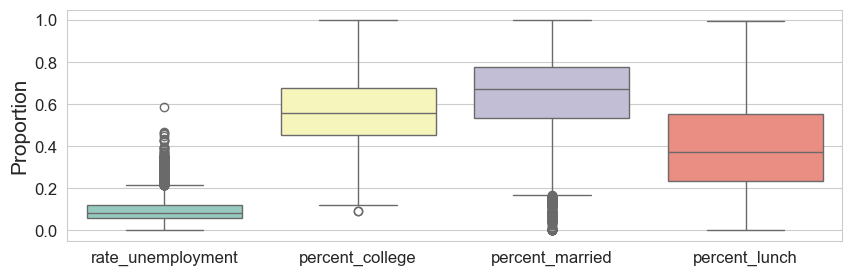

In [ ]:
# Boxplot of numerical predictors
plt.figure(figsize=(10, 3))

# Create a list of numerical predictors excluding 'median_income'
fractions = list(numerical_predictors)
fractions.remove('median_income')

# Plot boxplot of numerical predictors
sns.boxplot(data=df[fractions], palette="Set3")
plt.ylabel('Proportion', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

Show outliers and general spread of median income data

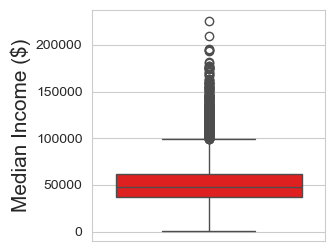

In [ ]:
# Plot boxplot of median income
plt.figure(figsize=(3,3))
sns.boxplot(data=df, y='median_income', color="red")
plt.ylabel('Median Income ($)', fontsize=15)
plt.show()

This notebook combined EdGap school-level socioeconomic indicators, NCES school metadata, and EDGE IPR estimates to assess how well socioeconomic factors explain variation in average ACT scores. After cleaning, merging, and imputing missing values, exploratory visuals (correlation heatmaps, pairplots, and stratified regression lines) were used to surface relationships between predictors and outcomes.

Key takeaways: Median household income showed only a modest association with average ACT after preprocessing and outlier handling. Measures related to economic disadvantage (percent free/reduced lunch and IPR estimates) displayed a stronger and more consistent relationship with ACT scores. Regression lines stratified by charter status indicated differences in slope/level but did not overturn the broader patterns observed across the dataset. 

Limitations: The analysis is affected by reporting bias, missingness, and measurement error in the source files; imputation reduces but does not remove these concerns. Correlations and stratified regressions are descriptive and do not imply causation; unobserved confounding and school-level selection effects remain possible. 

Next steps: Build predictive models with proper cross-validation and hold-out testing to quantify out-of-sample performance. Add uncertainty quantification (confidence intervals, bootstrap) and consider hierarchical models to capture state/district structure. Experiment with alternative imputation and feature-engineering strategies, and standardize charter labels for clearer subgroup comparisons.

In summary, 